<a href="https://colab.research.google.com/github/pansplawik/eegParkinsonCognitiveDisorders/blob/master/thirdVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

Importowanie pakietów

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import csv

Ściezki plików

In [3]:
labels = pd.read_csv('C:/Users/splaw/OneDrive/Pulpit/dyplom/eegParkinsonCognitiveDisorders/dataset.csv', sep=';')
labels['PD'] = labels['PD'].replace(2, 1)
path='C:/Users/splaw/OneDrive/Pulpit/dyplom/EEG'

Preprocesing danych

In [4]:
def load_epochs_from_dir(path, labels):
    epochs_array = []
    liczba=1
    filenames = sorted(os.listdir(path))
    for filename, label in zip(filenames, labels['PD']):
      print(filename)
      if filename.endswith('.edf'):
        filepath = os.path.join(path, filename)
        raw = mne.io.read_raw_edf(filepath, preload=True,verbose=False)
        raw.info.set_montage('standard_1020')
        raw.info['bads'].append('Oz')
        annotations = raw.annotations
        for i in range(len(annotations)):
              if annotations.description[i] != "eyes closed":
                annotations.description[i] = "BAD" 
        raw.set_annotations(annotations)
        raw.filter(1, 40, fir_design='firwin')
        events = mne.make_fixed_length_events(raw, duration=1.0)
        unique_events, unique_indices = np.unique(events[:, 0], return_index=True)
        events = events[unique_indices]
        tmin = 0
        tmax = 2
        baseline = (0, 2)
        reject = dict(
              eeg=80e-6,
              )
        epochs = mne.Epochs(raw, events, event_id=None, tmin=tmin, tmax=tmax, baseline=baseline, preload=True,reject_by_annotation='BAD',reject=reject,verbose=False)
        epochs_array.append([epochs, label])
        del raw
        del annotations
    return epochs_array

PSD

In [5]:
def psds(epochs_array, labels):
    data = []
    for epochs, label in zip(epochs_array, labels):
        if epochs is not None and len(epochs) > 0:
            epochs_data = epochs.get_data()
            epo_spectrum = mne.time_frequency.psd_array_multitaper(x=epochs_data, sfreq=512, fmin=4, fmax=8, verbose=False)
            psds_epoch, freqs = epo_spectrum
            vector=[]
            for p in psds_epoch:
                p = 10 * np.log10(p)
                data.append([p,label])
            del psds_epoch
            del freqs
            del epo_spectrum
    return data

In [6]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def Stats(y_test, y_pred):
    report = classification_report(y_test, y_pred, target_names=['0', '1'])
    print('Random Forest Classification Report:\n{}'.format(report))
    # Dokładność modelu
    acc = accuracy_score(y_pred,y_test)
    print("Accuracy of model: {}".format(acc))
    confusion_mat = confusion_matrix(y_test, y_pred)
    # Stwórz obrazek macierzy pomyłek
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
  

In [7]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def learningStats(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=np.linspace(.1, 1.0, 5),  # Można dostosować zakres rozmiarów danych treningowych
        cv=5,  # Liczba podziałów cross-validation
        scoring='accuracy',  # Można dostosować metrykę oceny (np. 'accuracy', 'f1', 'roc_auc', etc.)
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Wyświetlenie wyników w postaci wykresu
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, test_mean, label='Validation accuracy', color='green')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


In [ ]:
data = load_epochs_from_dir(path,labels)
df = pd.DataFrame(data, columns=['value', 'label'])
df.to_csv('data.csv', index=False)

PD129.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished


PD130.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


PD131.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


PD132.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


PD133.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished


PD134.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished


PD135.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


PD136.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


PD137.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


PD138.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


PD139.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished


PD140.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished


PD141.edf
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


In [ ]:
psd = psds([epochs for epochs, label in data], [label for epochs, label in data])
df = pd.DataFrame(psd, columns=['psds', 'label'])
df.to_csv('psd.csv', index=False)

Tworzenie zestawów

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
X_train, X_test, y_train, y_test = train_test_split(df['psds'], df['label'], test_size=0.1, random_state=42)
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_train=y_train.transpose()
y_test=np.array(y_test)
y_test=y_test.transpose()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2739
           1       0.84      0.79      0.81      2588

    accuracy                           0.82      5327
   macro avg       0.83      0.82      0.82      5327
weighted avg       0.83      0.82      0.82      5327

Accuracy of model: 0.824479068894312


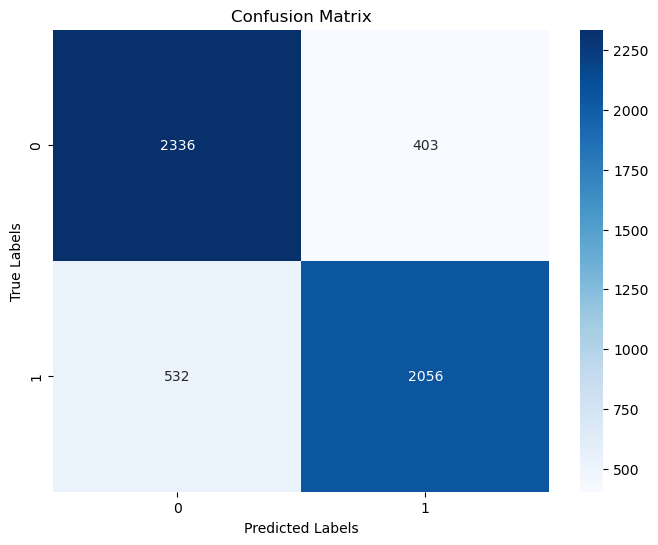

In [ ]:
from mne.decoding import Vectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Tworzenie i trenowanie modelu SVM
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), SVC())
clf_svm_pip.fit(list(X_train), y_train)
# Przewidywanie etykiet dla danych testowych
predictions_svm = clf_svm_pip.predict(list(X_test))

Stats(y_test,predictions_svm)
# Walidacja krzyżowa z k-fold
#k = 5  # Liczba podziałów
#scores = cross_val_score(clf_svm_pip, list(X_train), y_train, cv=k, scoring='accuracy')
# Obliczanie średniej i odchylenia standardowego z poszczególnych iteracji
#mean_accuracy = scores.mean()
#std_accuracy = scores.std()
#print('Cross-Validation Results ({}-fold)'.format(k))
#print('Mean Accuracy:', mean_accuracy)
#print('Standard Deviation:', std_accuracy)
learningStats(clf_svm_pip,list(X_train),y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definiowanie siatki parametrów do przetestowania
param_grid = {
    'svc__C': [0.2, 1],
    'svc__kernel': ['linear', 'rbf'],
}

# Utworzenie modelu z procedurą Grid Search
grid_search = GridSearchCV(clf_svm_pip, param_grid, cv=k, scoring='accuracy')

# Trenowanie modelu z Grid Search
grid_search.fit(X_train, y_train)


# Get the best estimator from grid search
best_clf = grid_search.best_estimator_

# Predict labels for test data
y_pred = best_clf.predict(X_test)

Stats(y_test,y_pred)

# Cross-validation with k-fold
# k = 5  # Number of folds
# scores = cross_val_score(best_clf,list(X_train), y_train, cv=k, scoring='accuracy')

# # Compute mean and standard deviation of accuracy
# mean_accuracy = scores.mean()
# std_accuracy = scores.std()

# print('Cross-Validation Results ({}-fold)'.format(k))
# print('Mean Accuracy:', mean_accuracy)
# print('Standard Deviation:', std_accuracy)

# # Best hyperparameters from grid search
# best_params = grid_search.best_params_
# print('Best Hyperparameters:', best_params)
learningStats(clf_svm_pip,list(X_train),y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import Vectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
# Definiowanie modelu
clf = make_pipeline(
    StandardScaler(),
    Vectorizer(),
    RandomForestClassifier()
)

clf.fit(X_train.reshape(-1, 1), y_train)
y_pred = clf.predict(X_test.reshape(-1, 1))

Stats(y_test,y_pred)

# Walidacja krzyżowa z k-fold
# k = 5  # Liczba podziałów
# scores = cross_val_score(clf, X_train.reshape(-1, 1), y_train, cv=k, scoring='accuracy')


# # Obliczanie średniej i odchylenia standardowego z poszczególnych iteracji
# mean_accuracy = scores.mean()
# std_accuracy = scores.std()

# print('Cross-Validation Results ({}-fold)'.format(k))
# print('Mean Accuracy:', mean_accuracy)
# print('Standard Deviation:', std_accuracy)
learningStats(clf_svm_pip,X_train.reshape(-1, 1),y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import Vectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
clf = make_pipeline(
StandardScaler(),
Vectorizer(),
LogisticRegression() # Używamy regresji logistycznej z domyślnymi parametrami
)

clf.fit(X_train.reshape(-1, 1), y_train)

#Przewidywanie etykiet dla danych testowych
y_pred = clf.predict(X_test.reshape(-1, 1))
Stats(y_test,y_pred)
# k = 5  # Liczba podziałów
# scores = cross_val_score(clf, X_train.reshape(-1, 1), y_train, cv=k, scoring='accuracy')


# # Obliczanie średniej i odchylenia standardowego z poszczególnych iteracji
# mean_accuracy = scores.mean()
# std_accuracy = scores.std()

# print('Cross-Validation Results ({}-fold)'.format(k))
# print('Mean Accuracy:', mean_accuracy)
# print('Standard Deviation:', std_accuracy)
learningStats(clf,X_train.reshape(-1, 1),y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import Vectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Define the pipeline
clf = make_pipeline(
    StandardScaler(),
    Vectorizer(),
    LogisticRegression()
)

# Define the parameter grid for grid search
param_grid = {
    'logisticregression__C': [0.1, 1.0, 10.0],  # Regularization parameter
    'logisticregression__solver': ['liblinear', 'saga']  # Solver for logistic regression
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train.reshape(-1, 1), y_train)

# Get the best estimator from grid search
best_clf = grid_search.best_estimator_

# Predict labels for test data
y_pred = best_clf.predict(X_test.reshape(-1, 1))
Stats(y_test,y_pred)

# k = 5  # Number of folds
# scores = cross_val_score(best_clf, X_train.reshape(-1, 1), y_train, cv=k, scoring='accuracy')
# # Compute mean and standard deviation of accuracy
# mean_accuracy = scores.mean()
# std_accuracy = scores.std()

# print('Cross-Validation Results ({}-fold)'.format(k))
# print('Mean Accuracy:', mean_accuracy)
# print('Standard Deviation:', std_accuracy)

# # Best hyperparameters from grid search
# best_params = grid_search.best_params_
# print('Best Hyperparameters:', best_params)
learningStats(clf,X_train.reshape(-1, 1),y_train)